# Convolutional Neural Networks

In this notebook you'll learn how to:

1. Create CNNs for image classification
2. Make use of GPUs
3. How to evaluate your trained model.

In [ ]:
!pip3 install torch torchaudio torchvision torchtext torchdata scikit-learn pandas

# Data Setup

We'll continue working with the Fashion-MNIST dataset for now.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

# Convolution

The most straightforward way to think about two-dimensional convolution is:

1. Take two matrices, and "slide" one over the other. The sliding matrix (the kernel) is usually significantly smaller than the matrix it moves along (e.g, 3x3)
2. Each value in the input matrix is multiplied by the kernel value above it, and summed together.
3. If the center of the kernel matrix is at position (i, j) on the larger matrix, the value in the output matrix at (i, j) is equal to the above (with some caveats due to padding).
4. This can change the shape of the output compared to the input.


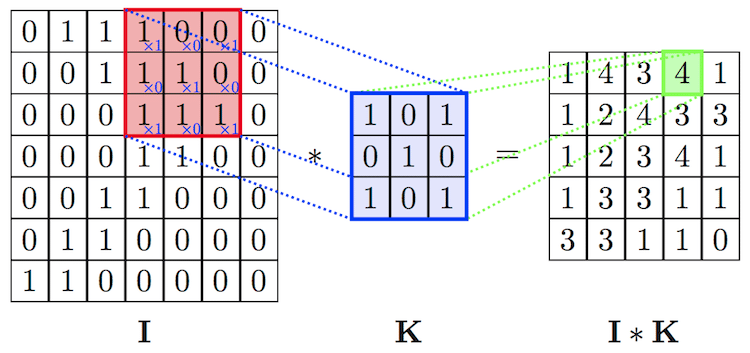

We can experiment with this in PyTorch. Starting with the original image of a boot:

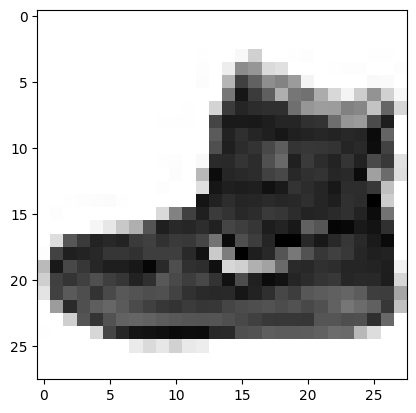

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
import numpy as np

x, _ = training_set[0]

npimg = x.numpy()
npimg = np.squeeze(npimg)
plt.imshow(npimg, cmap="Greys")
plt.show()

torch.Size([1, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([1, 26, 26])


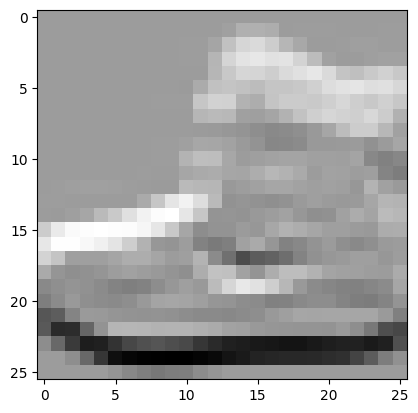

In [ ]:
# Kernel of shape:
# [  1  1  1 ]
# [  0  0  0 ]
# [ -1 -1 -1 ]
kernel = torch.Tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
kernel = kernel.unsqueeze(dim=0).unsqueeze(dim=0)
print(kernel.shape)
print(x.shape)

# Apply convolution
output = torch.nn.functional.conv2d(x, kernel)
print(output.shape)

npimg = output.numpy()
npimg = np.squeeze(npimg)
plt.imshow(npimg, cmap="Greys")
plt.show()

**Can you determine what this kernel might doing to the image?**

Sometimes, we don't want the convolution action to downsample our input image.

Other times, we might wish to more aggressively, and intentionally, downsample.

We can control this with the stride and padding inputs.

In [ ]:
# More aggressive down-sampling
# Stride controls how "far" the kernel slides as it moves along the input.
output = torch.nn.functional.conv2d(x, kernel, stride=2)
print(output.shape)

torch.Size([1, 13, 13])


In [ ]:
# No downsampling at all
# If padding is 'same' you can only use stride 1.
output = torch.nn.functional.conv2d(x, kernel, padding='same')
print(output.shape)

torch.Size([1, 28, 28])


# Convolutional Neural Networks

Above, we manually specified the kernel to be convolved with the input image.

The power of convolutional neural networks is that they learn "useful" kernels during the training process. By stacking large amounts of these kernels together, they can learn to effectively classify images.

Compared to fully connected networks, they also have significantly reduced parameter counts (as not every input is connected to every neuron). Instead, each filter simply views part of the image at any given time.

To build a CNN, we make use of PyTorch's built-in Conv2D layers, combined with MaxPooling.

**MaxPooling** is a form of dimensionality reduction. This encourages the CNN to keep only the features most relevant to the classification problem at hand.

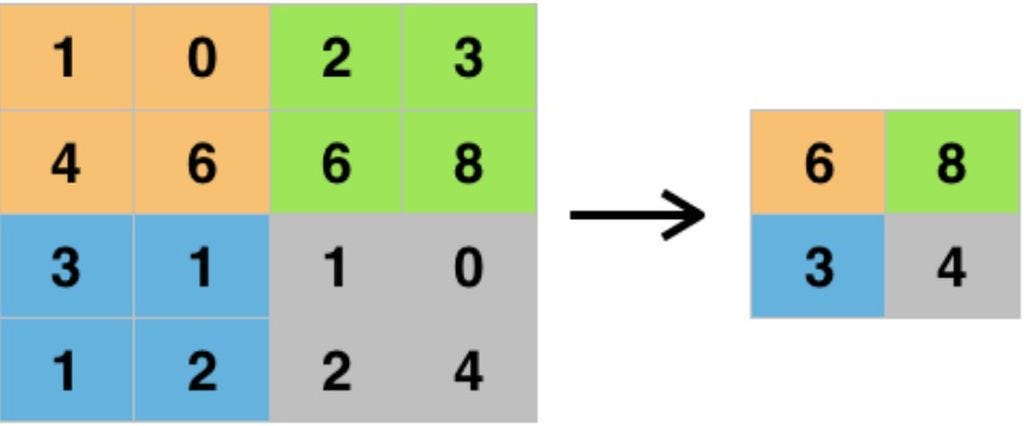

Implementing a CNN is broadly similar to our previous MLP implementation. However, instead of being majority linear layers, we use convolutional layers to learn features from the image, and downsampling in-between to preserve only the most important features.

In [ ]:
import torch.nn.functional as F

class FashionCNN(torch.nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    # In channels: generally 1 for grayscale, 3 for color.
    # Out channels: How many "feature maps" to output.
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding='same')
    self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
    self.fc1 = torch.nn.Linear(in_features=7*7*8, out_features=10)

    # Re-use the same max pooling layer for downsampling.
    # Kernel size sets the downsample amount.
    self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    # Useful to remember the shape of the input
    x = F.relu(self.conv1(x)) # 28 x 28
    x = self.maxpool(x) # 14 x 14
    x = F.relu(self.conv2(x)) # 14 x 14
    x = self.maxpool(x) # 7 x 7
    x = x.view(-1, 7 * 7 * 8) # Flatten
    x = self.fc1(x)

    return x

# Test the model
fashion_model = FashionCNN()
test_input = torch.zeros((1, 1, 28, 28))
output = fashion_model(test_input)
print(output.shape)

pytorch_total_params = sum(p.numel() for p in fashion_model.parameters())

# How does this compare to the MLP from last week?
print(f"Total network parameters: {pytorch_total_params}")

torch.Size([1, 10])
Total network parameters: 4266


In [ ]:
class FashionCNN(torch.nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding='same')
    self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
    self.fc1 = torch.nn.Linear(in_features=7*7*8, out_features=10)

    self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    x = x.view(-1, 7 * 7 * 8)

    x = self.fc1(x)

    return x

Our training loop for a CNN is exactly the same as for the MLP.

In [ ]:
# The cross-entropy loss
loss_fn = torch.nn.CrossEntropyLoss()
# An SGD Optimiser
optimizer = torch.optim.SGD(fashion_model.parameters(), lr=0.001, momentum=0.9)

epoch_losses = []
EPOCHS = 10

for epoch in range(0, EPOCHS):
  epoch_loss = 0
  # Run in a loop for n epochs
  for idx, data in enumerate(training_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = fashion_model(inputs)

    loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # Print the loss (normalised by total batches)
  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  epoch_losses.append(epoch_loss / len(training_loader))

plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("CNN Loss")
plt.title("Training Curve")
plt.show()

NameError: name 'torch' is not defined

Try:

1. Changing the learning rate/momentum parameters
2. Changing the optimiser entirely
3. Adding more layers
4. Adjusting the kernel sizes (e.g, 5x5, 7x7)

## A more complex dataset

Fashion-MNIST is somewhat of a simple dataset. We can also take a look and see the differences in performance on a more complex dataset: [Imagenette](https://github.com/fastai/imagenette).

This is a small subset of the Imagenet dataset.

100%|██████████| 342M/342M [00:06<00:00, 51.2MB/s]


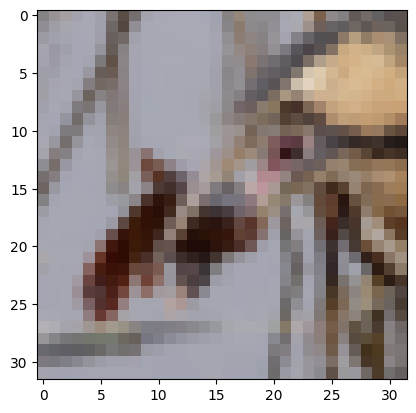

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms

# Resize to 32x32 for now, as otherwise the examples will take too long to run
# Can change this to see impact on training.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32))])

training_set = torchvision.datasets.Imagenette('.', split="train", size="320px", transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

x, _ = training_set[8]

npimg = x.numpy()
npimg = np.squeeze(npimg)
# Swap the channel dimension to the last dim, which matplotlib expects.
npimg = np.transpose(npimg, axes=(1, 2, 0))
plt.imshow(npimg)
plt.show()

# You might need to change the resolution of the images
# to determine what the image is below...

We'll define two different models to accomplish the same task - learn to classify this dataset.

In [ ]:

# Let's try two different classifiers for this dataset.

# A shallow MLP
class INetMLP(torch.nn.Module):
    def __init__(self):
        super(INetMLP, self).__init__()
        self.res = 32
        self.fc1 = torch.nn.Linear(3 * self.res * self.res, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 3 * self.res * self.res)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# And a shallow CNN
class INetCNN(torch.nn.Module):
    def __init__(self):
      super(INetCNN, self).__init__()
      self.res = int(32 / 4)
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), padding='same')
      self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
      self.fc1 = torch.nn.Linear(in_features=self.res*self.res*8, out_features=10)

      self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool(x)

      x = F.relu(self.conv2(x))
      x = self.maxpool(x)

      # Flatten before applying the linear layer.
      x = x.view(-1, self.res * self.res * 8)
      x = self.fc1(x)

      return x

## GPUs

However, a CPU is no longer powerful enough to run these models on a CPU.

We'll have to train these on the GPU. To do this, first make a copy of this notebook, and the click the dropdown on the right hand side, select "Change runtime type" and choose "T4 GPU"

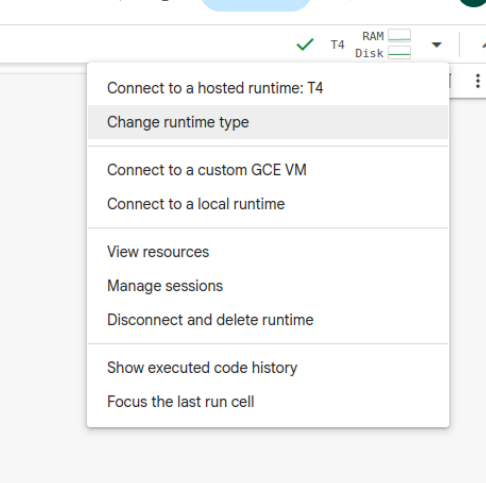

Total MLP network parameters: 379774
Total CNN network parameters: 5538
Device available: cuda
Model: CNN Epoch 0 loss: 2.2926186927267023
Model: CNN Epoch 1 loss: 2.214335748875463
Model: CNN Epoch 2 loss: 2.0547114179746524
Model: CNN Epoch 3 loss: 1.9824585753518182
Model: CNN Epoch 4 loss: 1.9362896386836026
Model: CNN Epoch 5 loss: 1.8823227515897236
Model: CNN Epoch 6 loss: 1.8339767282879031
Model: CNN Epoch 7 loss: 1.7813237841064866
Model: CNN Epoch 8 loss: 1.7290089831158921
Model: CNN Epoch 9 loss: 1.6895271523578748
Model: MLP Epoch 0 loss: 2.2641501692501276
Model: MLP Epoch 1 loss: 2.1343871777927554
Model: MLP Epoch 2 loss: 2.0114833865616775
Model: MLP Epoch 3 loss: 1.9567016765878007
Model: MLP Epoch 4 loss: 1.9173478178075842
Model: MLP Epoch 5 loss: 1.8793696277850382
Model: MLP Epoch 6 loss: 1.8438983587799846
Model: MLP Epoch 7 loss: 1.8156133845851228
Model: MLP Epoch 8 loss: 1.784620678908116
Model: MLP Epoch 9 loss: 1.7605783262768306


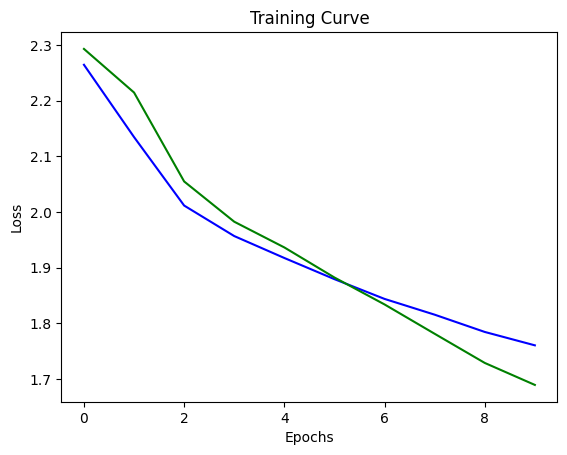

In [ ]:
cnn = INetCNN()
mlp = INetMLP()

print(f"Total MLP network parameters: {sum(p.numel() for p in mlp.parameters())}")
print(f"Total CNN network parameters: {sum(p.numel() for p in cnn.parameters())}")

# You can check if a GPU is available with:

print(f"Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# cuda = GPU
# cpu = CPU

def train_model(model, dataloader, name):
  # To use the GPU, we need to move the models, and data, over to the GPU device.
  # We do this by calling .to('cuda') as follows

  # You need to have changed your runtime to include a GPU for this to work.
  model = model.to('cuda')

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  epoch_losses = []
  EPOCHS = 10

  for epoch in range(0, EPOCHS):
    epoch_loss = 0
    # Run in a loop for n epochs
    for idx, data in enumerate(dataloader):
      inputs, labels = data

      # If we place the model on the GPU, the training data also needs to be on the GPU.
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = loss_fn(outputs, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f"Model: {name} Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
    epoch_losses.append(epoch_loss / len(training_loader))

  return epoch_losses


epoch_losses = train_model(cnn, training_loader, "CNN")
mlp_losses = train_model(mlp, training_loader, "MLP")

plt.plot(range(0, len(epoch_losses)), mlp_losses, color='blue')
plt.plot(range(0, len(epoch_losses)), epoch_losses, color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

**What happens if you change the resolution of the input images? The dataset supports up to 224x224 pixels.** The MLP may work better at smaller resolutions - but can't scale well.

**Try making the CNN deeper - can you improve performance?** *Hint: You'll need to make sure the input and output sizes match up after max-pooling.*

# Evaluating models

So far, we've only looked at training performance. In reality, you're likely to use your model on data which it hasn't seen before. To simulate this, and determine how well the model might work in the real world, we use a _test set_.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

test_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

We'll run this held-out test set through our previously trained Fashion-MNIST CNN (looking at inference only) and examine some performance metrics.

The output of the neural network for a given input is a 10-dimensional tensor. Each index in the tensor represents a class, and the value at that index represents how strongly the neural network believes the input *is that class*.

To get at an accuracy score, we can take the argmax of each 10D tensor and compare this to the labels.

In [ ]:
# Place the model into evaluation mode ( undo with model.train() )
fashion_model.eval()
total_correct = 0
all_y = np.array([])
all_labels = np.array([])

for idx, data in enumerate(test_loader):
  inputs, labels = data

  # Forward pass
  outputs = fashion_model(inputs)

  # The greatest value in the vector represents the class
  # Find the index of this value and compare to the ground truth
  correct_output_vector = (labels == torch.argmax(outputs, axis=1))

  # Sum over all correct in the batch
  batch_correct = torch.sum(correct_output_vector)

  # Detach from Pytorch (not strictly necessary but easier to work with)
  batch_correct = batch_correct.numpy()

  # Store all the labels and predictions for some downstream analysis.
  all_y = np.concatenate((all_y, torch.argmax(outputs, axis=1).numpy()))
  all_labels = np.concatenate((all_labels, labels.numpy()))

  total_correct += batch_correct

# Get the accuracy.
# Feel free to modify the fashion_cnn layers and hyperparameters
# and see if you can improve upon the example accuracy of 86.86
accuracy = (total_correct / len(test_set)) * 100
print(f"Accuracy: {np.round(accuracy, 2)}%")


Accuracy: 86.86%


As this is a multi-class classification problem, it's also useful to inspect what we're predicting correctly, and which classes the network is confusing for one another.

We can do this with a confusion matrix, with a helper function provided by scikit-learn.

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

cm = confusion_matrix(all_labels, all_y)
ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(xticks_rotation=90)

KeyboardInterrupt: 

From this we can see that even quite a simple network can achieve a decent performance on the FashionMNIST dataset - and potentially on real-world data (of matching type).

The confusion matrix reveals that the network makes some understandable errors; confusing shirts with T-shirts and coats, sneakers with ankle boots, and coats with pullovers.


**Try generating a similar confusion for the imagenette example networks above**

Hints:

1. The trained imagenet models are on the GPU - you can either move these back to the CPU with a call such as: `model = model.to('cpu')` or you can place the test data onto the GPU (recommended)
2. If the test data and model is on the GPU, when you come to using numpy to calculate the accuracy, you'll need to use `.cpu()` on the tensors to move them from the GPU to the CPU (e.g): `batch_correct = batch_correct.cpu().numpy()`

In [ ]:
imagenette_classes = ("tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32))])

imagenette_testset = torchvision.datasets.Imagenette('.', split="val", size="160px", transform=transform, download=True)
imagenette_testloader = torch.utils.data.DataLoader(imagenette_testset, batch_size=32, shuffle=True)


# Confusion matrix for Imagenette code

Accuracy: 37.89%


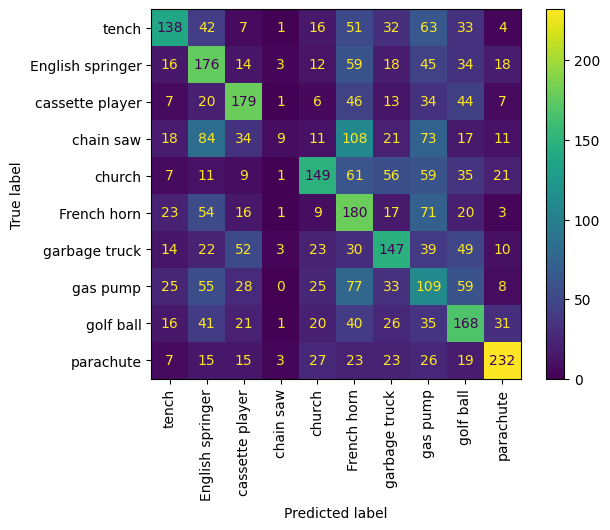

In [ ]:
cnn.eval()
total_correct = 0
all_y = np.array([])
all_labels = np.array([])

for idx, data in enumerate(imagenette_testloader):
  inputs, labels = data
  # Don't forget to copy the data to the GPU

  inputs = inputs.to('cuda')
  labels = labels.to('cuda')

  # Forward pass
  outputs = cnn(inputs)

  # The greatest value in the vector represents the class
  # Find the index of this value and compare to the ground truth
  correct_output_vector = (labels == torch.argmax(outputs, axis=1))
  # Sum over all correct in the batch
  batch_correct = torch.sum(correct_output_vector)
  # Detach from Pytorch (not strictly necessary but easier to work with)

  # Use .cpu() to move the tensor back from the gpu to the cpu to process with numpy
  batch_correct = batch_correct.cpu().numpy()

  # Store all the labels and predictions for some downstream analysis.
  all_y = np.concatenate((all_y, torch.argmax(outputs.cpu(), axis=1).numpy()))
  all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

  total_correct += batch_correct

accuracy = (total_correct / len(imagenette_testset)) * 100
print(f"Accuracy: {np.round(accuracy, 2)}%")

cm = confusion_matrix(all_labels, all_y)
ConfusionMatrixDisplay(cm, display_labels=imagenette_classes).plot(xticks_rotation=90)